In [1]:
import numpy as np
import torch
import cupy as cu
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
arr = torch.zeros(100, 100, device=device)
arr[25:50, 25:50] = 1
arr

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [5]:
# plt.imshow(arr.cpu().numpy())

In [6]:
cust_filter = torch.tensor([[[0, 1, 0], [0, -1, 0], [0, 0, 0]], 
                            [[0, 0, 0], [0, -1, 1], [0, 0, 0]],
                            [[0, 0, 0], [0, -1, 0], [0, 1, 0]],
                            [[0, 0, 0], [1, -1, 0], [0, 0, 0]]], device=device, dtype=torch.float)

In [7]:
cust_filter, cust_filter.shape

(tensor([[[ 0.,  1.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  1.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  1.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 1., -1.,  0.],
          [ 0.,  0.,  0.]]], device='cuda:0'),
 torch.Size([4, 3, 3]))

In [8]:
vectors = torch.nn.functional.conv2d(input=arr[None, None, ...], weight=cust_filter[:, None], padding=1)
vectors = vectors[0]
vectors[0, 0, :] = 0
vectors[1, :, -1] = 0
vectors[2, -1, :] = 0
vectors[3, :, 0] = 0
vectors, vectors.shape

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

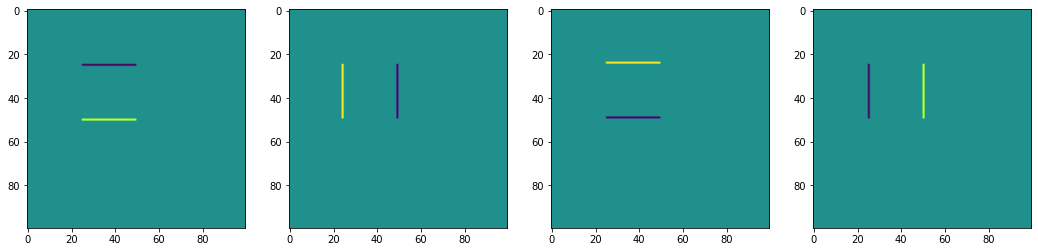

In [9]:
plt.rcParams['figure.figsize'] = [18, 12]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(vectors[i].cpu().numpy())

In [10]:
square = torch.ones_like(vectors)
square[:-1] += vectors[:-1] ** 2 + vectors[1:] ** 2
square[-1] +=  vectors[0] ** 2 + vectors[-1] ** 2
square = torch.sqrt(square) / 2

In [11]:
square, square.shape

(tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ...,

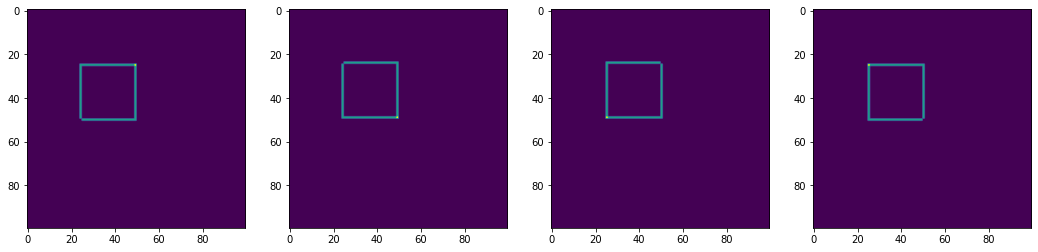

In [12]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(square[i].cpu().numpy())

In [13]:
square[0, 0, :] = 0
square[1, :, -1] = 0
square[2, -1, :] = 0
square[3, :, 0] = 0

In [14]:
vertex_area = square.sum(axis=0)

In [15]:
vertex_area, vertex_area.shape

(tensor([[1.0000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.0000],
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         ...,
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         [1.0000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.0000]],
        device='cuda:0'),
 torch.Size([100, 100]))

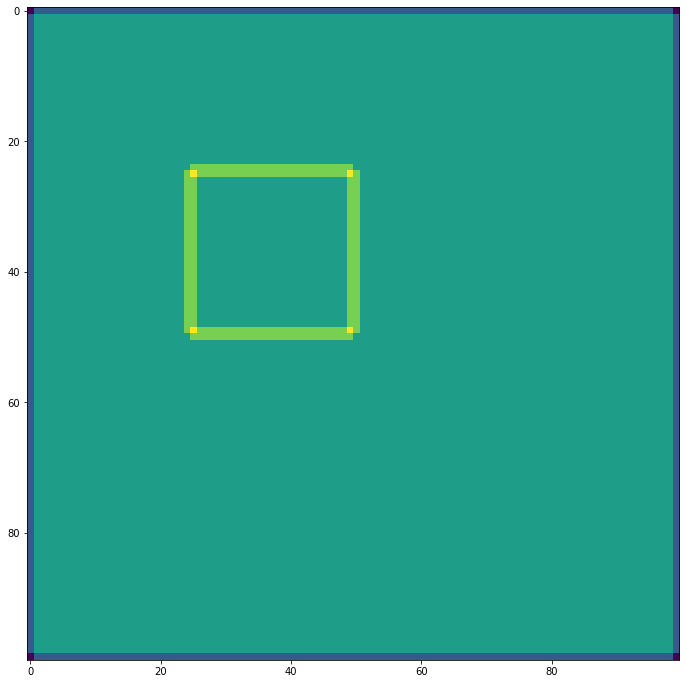

In [16]:
plt.imshow(vertex_area.cpu().numpy())

In [17]:
del square, arr
torch.cuda.empty_cache()

In [49]:
cotangens = torch.zeros_like(vectors)
cotangens[0] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[0] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[1] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))
cotangens[1] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[2] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[2] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[3] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[3] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))
cotangens

tensor([[[2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         ...,
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.]],

        [[2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         ...,
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.]],

        [[2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         ...,
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.]],

        [[2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         ...,
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 

tensor(1.4142, device='cuda:0')